## CatBoost

CatBoost algorithm is an improved generalized gradient boosting algorithm developed by Yandex in 2017 that can be used for both classification and regression tasks, which uses decision trees as base learners.

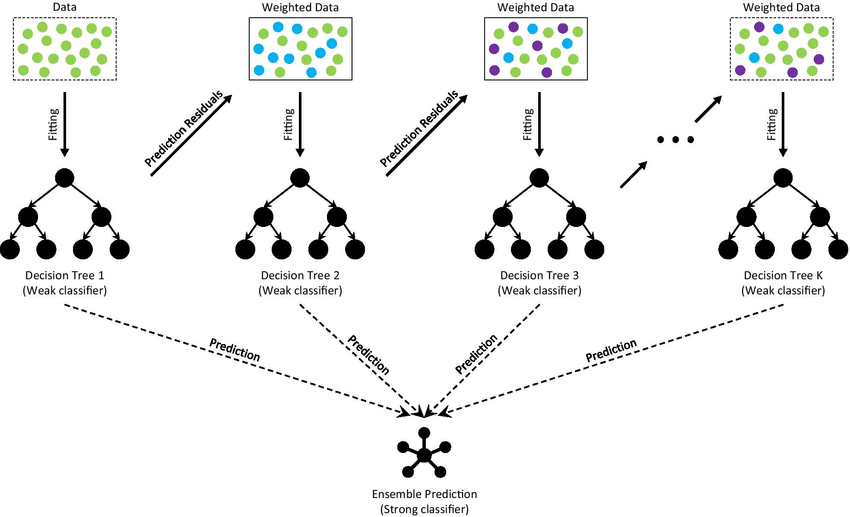

Unlike gradient boosting, CatBoost introduces "ordered" boosting method for categorical data and it introduces support for text data, which is not supported for all other gradient boosting algorithms.

<b>Requirement of feature scaling: No</b>

<b>Robust to outliers: Yes</b>

<b>Is multicollinearity an issue?: No</b>

<b>Advantages of CatBoost:</b>
1. Increases speed of training using GPU
2. Able to handle missing data
3. Minimum preprocessing required for categorical and text data
4. Captures non-linear relationships
5. Suitable for smaller datasets

<b>Disadvantages of CatBoost:</b>
1. Large space of hyperparameter tuning required
2. Difficult to interpret final model

<b>How does CatBoost handle missing values?:</b> Missing data for numerical features is handled by either replacing missing values with minimum value or maximum value.

<b>How does CatBoost handle categorical data?:</b>
1. Input categorical data is permuted in a random order
2. Convert label from floating point to integer based on quantization for regression or integer-encoded target class for classification
3. Transform categorical features to numerical features using one of the available methods (bucket, border, binarized target mean value and counter) with the following formula:

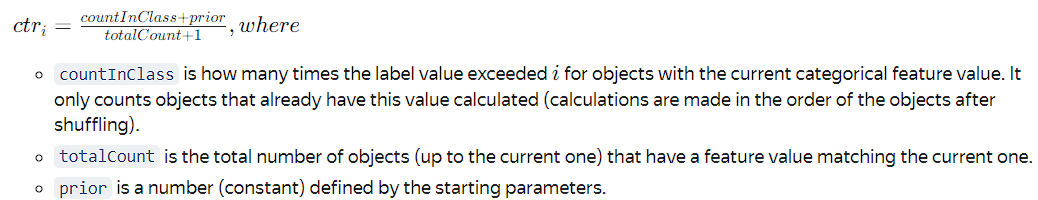

<b>How does CatBoost grow trees?:</b> Symmetrical wise (same decision splits used on both sides of tree)

More details about CatBoost can be found in the following official documentation: https://catboost.ai/en/docs/

## Booster types for CatBoost

1. Ordered: Usually provides better quality on small datasets, but may be slower than Plain method

2. Plain: Classic gradient boosting scheme

## Bootstrapping type for CatBoost

1. MVS (Minimum variance sampling): Uses expected gradient in each leaf, such that it samples a given number of top examples by expected gradient with probability of 1 and samples other examples with the same fixed probability. (Related hyperparameters: mvs_reg, sampling_unit)

2. Bayesian: Weights of samples are set using bayesian method. (Related hyperparameters: bagging_temperate, sampling_unit)

3. Bernoulli: Weights of samples are set with probability of 1/subsample (Related hyperparameters: subsample, sampling_unit)

4. Poisson: Weights of samples are set from Poisson distribution with parameter of -log(1-subsample) (Related hyperparameters: subsample, sampling_unit)

5. No: All training samples are used (Default)

Note that MVS is only supported in CPU, while Poisson is only supported in GPU

## Tree splitting methods for CatBoost

Catboost uses greedy-based algorithm approach, where all entries of input data is used during every split finding procedure.

In [1]:
# Import all required Python libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing, load_wine
from skopt import BayesSearchCV
from catboost import CatBoostClassifier, CatBoostRegressor
from skopt.space import Real, Integer, Categorical
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold

More details related to Exploratory Data Analysis for both regression and classification problem statement can be found in the following Jupyter Notebook within the same folder: EDA_Regression.ipynb and EDA_Classification.ipynb

## CatBoost for regression

<b>Important hyperparameters for CatBoostRegressor</b>:
1. loss_function : Specifies the learning task and the related learning objective. Represents the loss function to be minimized in the formula. ('RMSE', 'MAPE', 'MAE', 'Huber', 'R2')
2. iterations: Maximum number of estimators before boosting algorithm terminates
3. max_depth: Maximum depth of decision tree
4. min_data_in_leaf: Minimum number of samples in leaf node
4. learning_rate: Weight applied to each regressor at each boosting iteration. Higher learning rate increases contribution of each regressor. (Tradeoff between learning_rate and iterations values)
5. l2_leaf_reg: l2 regularization term on weights
6. random_strength: Amount of randomness for scoring splits when tree structure is selected that helps to reduce overfitting

In [2]:
data = fetch_california_housing()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'])
y.name = 'Median House Value ($100000)'

In [3]:
def nested_cv(X, y, pipeline, search_space = None):
    num_folds = 10
    skfold = KFold(n_splits=num_folds, shuffle=True, random_state=120)
    val_rmse, test_rmse = [], []
    for fold, (outer_train_idx, outer_test_idx) in enumerate(skfold.split(X, y)):
        X_train = X.iloc[outer_train_idx,:].reset_index(drop=True)
        y_train = y.iloc[outer_train_idx].reset_index(drop=True)
        X_test = X.iloc[outer_test_idx,:].reset_index(drop=True)
        y_test = y.iloc[outer_test_idx].reset_index(drop=True)
        search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10,
                               scoring= make_scorer(mean_squared_error, squared=False),refit=True, n_jobs=3)
        search.fit(X_train,y_train)
        val_rmse.append(search.best_score_)
        print(f'Validation RMSE for fold {fold+1}:',search.best_score_)
        print(f'Best hyperparameters for fold {fold+1}:', search.best_params_)
        y_pred = search.best_estimator_.predict(X_test)
        test_rmse.append(mean_squared_error(y_test,y_pred,squared=False))
        print(f'Test RMSE for fold {fold+1}:',mean_squared_error(y_test,y_pred,squared=False))
    print('----------------------')
    print('Average validation RMSE score:', np.mean(val_rmse))
    print('Average test RMSE score:', np.mean(test_rmse))

In [4]:
reg = CatBoostRegressor(random_state=120, iterations=100, verbose=False, loss_function='RMSE')
pipeline = Pipeline(steps=[])
pipeline.steps.append(('regression',reg))
search_space = dict()
search_space['regression__max_depth'] = Integer(4,10)
search_space['regression__min_data_in_leaf'] = Integer(1,1000)
search_space['regression__learning_rate'] = Real(0.01,0.3,'log-uniform')
search_space['regression__l2_leaf_reg'] = Real(2,10,'log-uniform')
search_space['regression__random_strength'] = Real(0.1,10,'log-uniform')
nested_cv(X, y, pipeline, search_space)

Validation RMSE for fold 1: 0.7393862470182582
Best hyperparameters for fold 1: OrderedDict([('regression__l2_leaf_reg', 4.281995037637112), ('regression__learning_rate', 0.018785449649421443), ('regression__max_depth', 7), ('regression__min_data_in_leaf', 721), ('regression__random_strength', 2.631623270132359)])
Test RMSE for fold 1: 0.647458493065252
Validation RMSE for fold 2: 0.82544207219893
Best hyperparameters for fold 2: OrderedDict([('regression__l2_leaf_reg', 7.5666048044455945), ('regression__learning_rate', 0.012606993485548374), ('regression__max_depth', 4), ('regression__min_data_in_leaf', 910), ('regression__random_strength', 0.47050232725698127)])
Test RMSE for fold 2: 0.7796881549823507
Validation RMSE for fold 3: 0.7814380673301228
Best hyperparameters for fold 3: OrderedDict([('regression__l2_leaf_reg', 9.857198552027652), ('regression__learning_rate', 0.015165127274394499), ('regression__max_depth', 7), ('regression__min_data_in_leaf', 499), ('regression__random_st

## CatBoost for Classification

<b>Important hyperparameters for CatBoostClassifier</b>:
1. loss_function : Specifies the learning task and the related learning objective. Represents the loss function to be minimized in the formula. ('Logloss', 'MultiClass')
2. iterations: Maximum number of estimators before boosting algorithm terminates
3. max_depth: Maximum depth of decision tree
4. min_data_in_leaf: Minimum number of samples in leaf node
5. learning_rate: Weight applied to each classifier at each boosting iteration. Higher learning rate increases contribution of each regressor. (Tradeoff between learning_rate and iterations values)
6. l2_leaf_reg: l2 regularization term on weights
7. random_strength: Amount of randomness for scoring splits when tree structure is selected that helps to reduce overfitting

<b>Methods to handle imbalanced dataset for classification</b>:
1. Resampling techniques (Oversampling/Combination of Oversampling and Undersampling - Less suitable for larger datasets due to high computation time)
2. Assign values to auto_class_weight hyperparameter

In [5]:
data = load_wine()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'])
y.name = 'Wine_Class'

In [6]:
X.nunique()

alcohol                         126
malic_acid                      133
ash                              79
alcalinity_of_ash                63
magnesium                        53
total_phenols                    97
flavanoids                      132
nonflavanoid_phenols             39
proanthocyanins                 101
color_intensity                 132
hue                              78
od280/od315_of_diluted_wines    122
proline                         121
dtype: int64

In [7]:
def nested_cv(X, y, pipeline, search_space = None):
    num_folds = 10
    skfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=120)
    val_f1, test_f1 = [], []
    for fold, (outer_train_idx, outer_test_idx) in enumerate(skfold.split(X, y)):
        X_train = X.iloc[outer_train_idx,:].reset_index(drop=True)
        y_train = y.iloc[outer_train_idx].reset_index(drop=True)
        X_test = X.iloc[outer_test_idx,:].reset_index(drop=True)
        y_test = y.iloc[outer_test_idx].reset_index(drop=True)
        search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10,scoring= make_scorer(f1_score, average='macro'),refit=True, n_jobs=1)
        search.fit(X_train,y_train)
        val_f1.append(search.best_score_)
        print(f'Validation F1 score for fold {fold+1}:',search.best_score_)
        print(f'Best hyperparameters for fold {fold+1}:', search.best_params_)
        y_pred = search.best_estimator_.predict(X_test)
        test_f1.append(f1_score(y_test,y_pred, average='macro'))
        print(f'Test F1 score for fold {fold+1}:',f1_score(y_test,y_pred, average='macro'))
        print()
        cmd = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        cmd.ax_.set_title(f"Confusion Matrix - CatBoostClassifier (Fold {fold+1})")
        plt.grid(False)
        plt.show()
        print()
    print('----------------------')
    print('Average validation F1 score:', np.mean(val_f1))
    print('Average test F1 score:', np.mean(test_f1))

Validation F1 score for fold 1: 0.9752389883489627
Best hyperparameters for fold 1: OrderedDict([('classification__auto_class_weights', 'None'), ('classification__l2_leaf_reg', 8.288711298595803), ('classification__learning_rate', 0.02651104414070385), ('classification__max_depth', 5), ('classification__min_data_in_leaf', 31), ('classification__random_strength', 1.189837260789787)])
Test F1 score for fold 1: 1.0



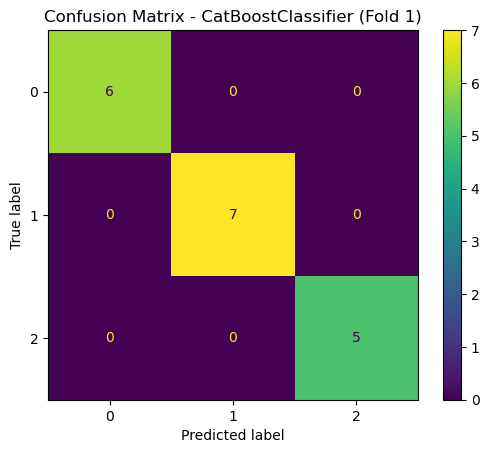


Validation F1 score for fold 2: 0.9624472761899063
Best hyperparameters for fold 2: OrderedDict([('classification__auto_class_weights', 'Balanced'), ('classification__l2_leaf_reg', 6.81220077498731), ('classification__learning_rate', 0.027759755101436683), ('classification__max_depth', 8), ('classification__min_data_in_leaf', 35), ('classification__random_strength', 1.1452582690599329)])
Test F1 score for fold 2: 1.0



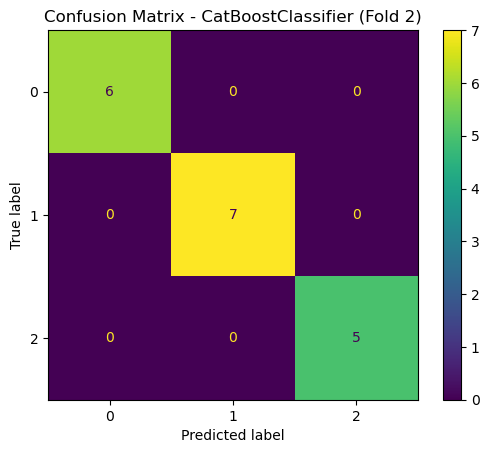


Validation F1 score for fold 3: 0.9810360897982381
Best hyperparameters for fold 3: OrderedDict([('classification__auto_class_weights', 'None'), ('classification__l2_leaf_reg', 2.5142845266728666), ('classification__learning_rate', 0.06818719661193302), ('classification__max_depth', 4), ('classification__min_data_in_leaf', 34), ('classification__random_strength', 6.019620375771545)])
Test F1 score for fold 3: 0.9487179487179486



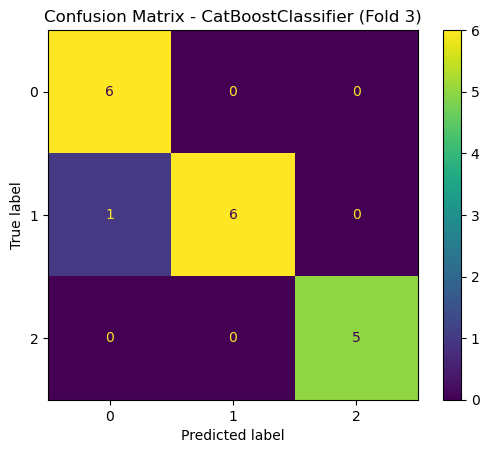


Validation F1 score for fold 4: 0.9814488864958646
Best hyperparameters for fold 4: OrderedDict([('classification__auto_class_weights', 'None'), ('classification__l2_leaf_reg', 3.0858752347375), ('classification__learning_rate', 0.09422233587845597), ('classification__max_depth', 8), ('classification__min_data_in_leaf', 20), ('classification__random_strength', 6.3885538210894675)])
Test F1 score for fold 4: 1.0



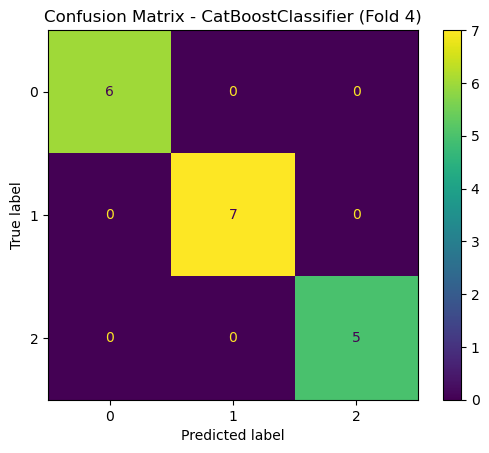


Validation F1 score for fold 5: 0.9817830552510859
Best hyperparameters for fold 5: OrderedDict([('classification__auto_class_weights', 'None'), ('classification__l2_leaf_reg', 3.509895288158942), ('classification__learning_rate', 0.18720248001507092), ('classification__max_depth', 9), ('classification__min_data_in_leaf', 17), ('classification__random_strength', 5.829789604398921)])
Test F1 score for fold 5: 1.0



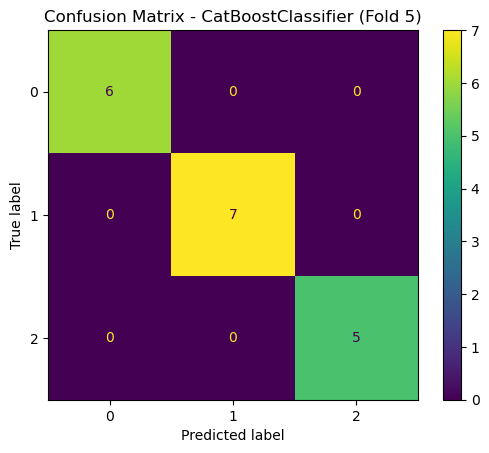


Validation F1 score for fold 6: 0.9693689839572194
Best hyperparameters for fold 6: OrderedDict([('classification__auto_class_weights', 'None'), ('classification__l2_leaf_reg', 8.380974598419124), ('classification__learning_rate', 0.03309346109834747), ('classification__max_depth', 7), ('classification__min_data_in_leaf', 49), ('classification__random_strength', 0.7505991603822477)])
Test F1 score for fold 6: 1.0



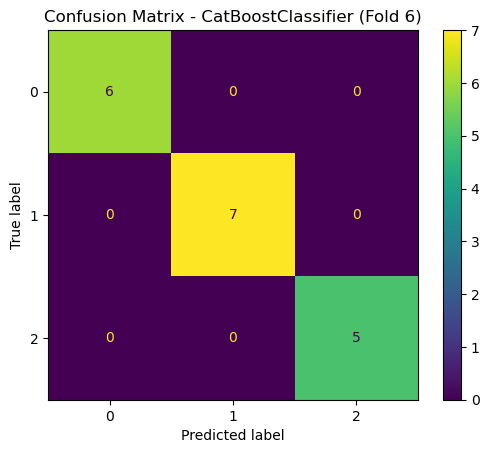


Validation F1 score for fold 7: 0.9690732115882204
Best hyperparameters for fold 7: OrderedDict([('classification__auto_class_weights', 'None'), ('classification__l2_leaf_reg', 5.896585395227697), ('classification__learning_rate', 0.018612683700264764), ('classification__max_depth', 9), ('classification__min_data_in_leaf', 33), ('classification__random_strength', 1.3211349822642244)])
Test F1 score for fold 7: 1.0



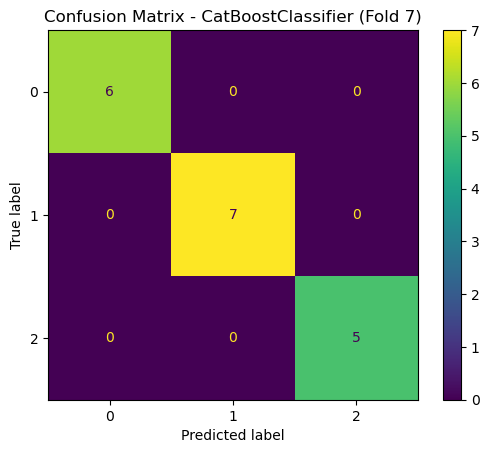


Validation F1 score for fold 8: 0.9752486501847116
Best hyperparameters for fold 8: OrderedDict([('classification__auto_class_weights', 'None'), ('classification__l2_leaf_reg', 9.324436850729203), ('classification__learning_rate', 0.012458816460356213), ('classification__max_depth', 8), ('classification__min_data_in_leaf', 7), ('classification__random_strength', 1.7896624817774829)])
Test F1 score for fold 8: 0.9440559440559441



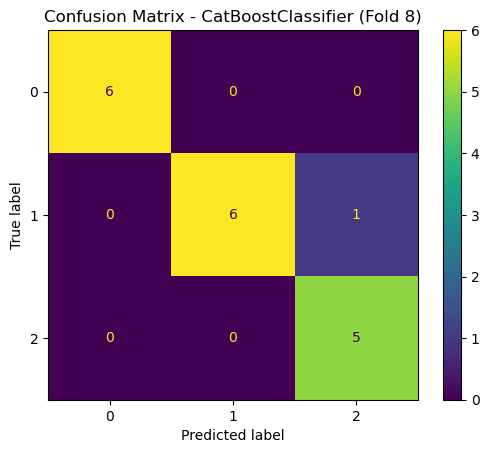


Validation F1 score for fold 9: 0.9758836691045601
Best hyperparameters for fold 9: OrderedDict([('classification__auto_class_weights', 'SqrtBalanced'), ('classification__l2_leaf_reg', 6.423867564940635), ('classification__learning_rate', 0.0166273523344194), ('classification__max_depth', 8), ('classification__min_data_in_leaf', 26), ('classification__random_strength', 0.7916224807100676)])
Test F1 score for fold 9: 0.9373219373219372



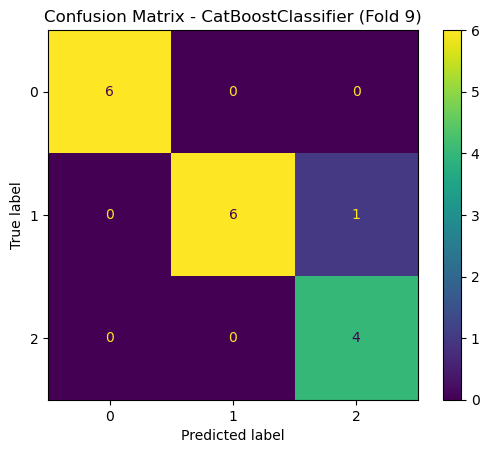


Validation F1 score for fold 10: 0.9760953914577103
Best hyperparameters for fold 10: OrderedDict([('classification__auto_class_weights', 'None'), ('classification__l2_leaf_reg', 2.11055957611125), ('classification__learning_rate', 0.13315963077668502), ('classification__max_depth', 5), ('classification__min_data_in_leaf', 44), ('classification__random_strength', 0.5612653188177307)])
Test F1 score for fold 10: 0.8850408850408851



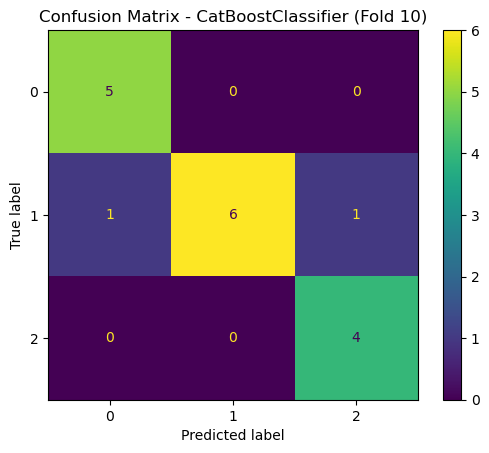


----------------------
Average validation F1 score: 0.9747624202376478
Average test F1 score: 0.9715136715136714


In [8]:
clf = CatBoostClassifier(random_state=120, iterations=100, verbose=False, loss_function='MultiClass')
pipeline = Pipeline(steps=[])
pipeline.steps.append(('classification',clf))
search_space = dict()
search_space['classification__max_depth'] = Integer(4,10)
search_space['classification__min_data_in_leaf'] = Integer(1,50)
search_space['classification__learning_rate'] = Real(0.01,0.3,'log-uniform')
search_space['classification__l2_leaf_reg'] = Real(2,10,'log-uniform')
search_space['classification__random_strength'] = Real(0.1,10,'log-uniform')
search_space['classification__auto_class_weights'] = Categorical(['None', 'Balanced', 'SqrtBalanced'])
nested_cv(X, y, pipeline, search_space)

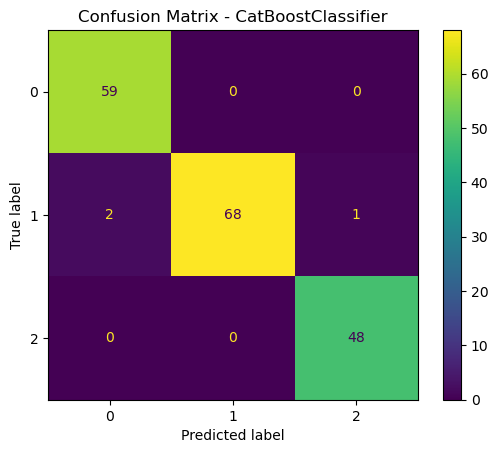

In [9]:
search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10, scoring= make_scorer(f1_score, average='macro'),refit=True, n_jobs=1)
search.fit(X,y)
y_pred = search.best_estimator_.predict(X)
cmd = ConfusionMatrixDisplay.from_predictions(y, y_pred)
cmd.ax_.set_title("Confusion Matrix - CatBoostClassifier")
plt.grid(False)
plt.show()